Matplotlib created a temporary config/cache directory at /tmp/matplotlib-y2gkxf55 because the default path (/home/own3/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


     |████████████████████████████████| 2.6 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 4.4 MB/s eta 0:00:011
  Created wheel for pypdf2: filename=PyPDF2-1.26.0-py3-none-any.whl size=61085 sha256=7523677667ba4f5264a9553d10648e792e649de71856361b9362ccf4c7fcd826
  Stored in directory: /tmp/pip-ephem-wheel-cache-urhya2wr/wheels/b1/1a/8f/a4c34be976825a2f7948d0fa40907598d69834f8ab5889de11
Successfully built pypdf2


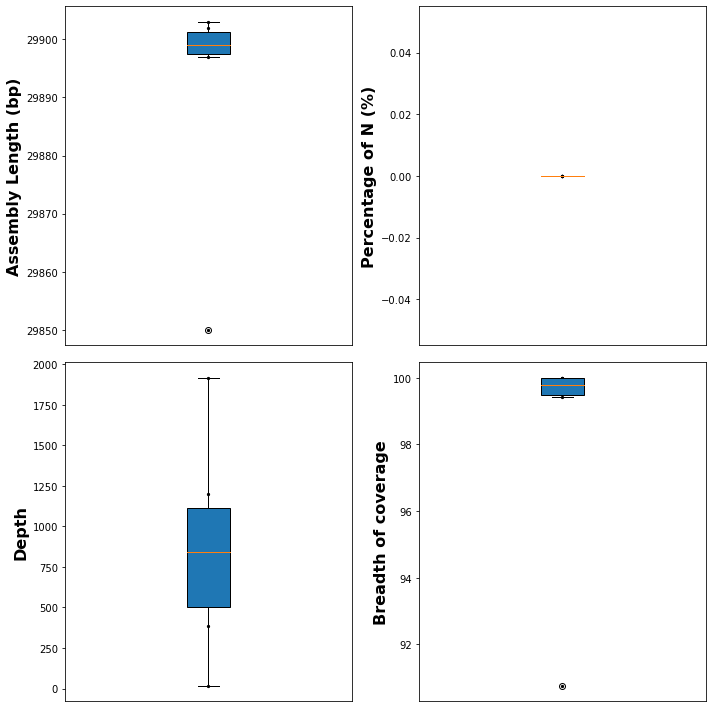

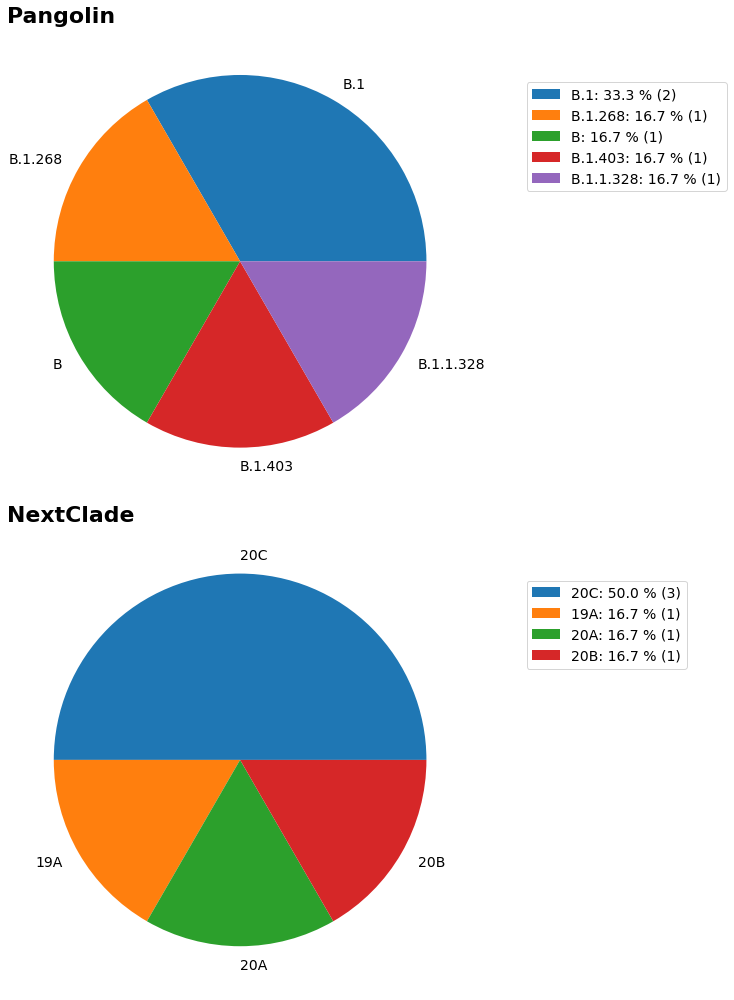

In [1]:
#import dependences 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime 

#install reportlab to format the PDF report
!pip install reportlab
!pip install pypdf2

from reportlab.lib.pagesizes import A4
from reportlab.platypus import *
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import *
from textwrap import wrap
from reportlab.pdfgen import canvas
from PyPDF2 import PdfFileWriter, PdfFileReader
from io import StringIO

#  input aggregating excel spreadsheet
df=pd.read_excel(r'REPORT_SC2_PHL_1616557457.xlsx')

# output the pdf report
output_pdf = "Run_report_v2.pdf"
styles = getSampleStyleSheet()
margin=2*cm
doc = SimpleDocTemplate(output_pdf,pagesize=A4,
                        rightMargin=margin,leftMargin=margin,
                        topMargin=margin,bottomMargin=margin)
doc_width, doc_height = A4
elements = []


#output report's title and date
head="SARS-Cov-2 Run Report"
now = datetime.datetime.now()
date= now.strftime("%m/%d/%Y")
elements.append(Paragraph(head, styles['Title']))
elements.append(Paragraph("<para align=center>"+date+"</para>", styles['Normal']))

#output the summary statistics
summary = [
    ["Type", "Count"],
    ["Total Samples", len(df["Sample"])],
    ["Assembly Passed", len(df.loc[df["Assem_Stat"]=="PASS"])],
    ["VADR Passed", len(df.loc[df["VADR_Stat"]=="PASS"])],
    ["Number of Pangolineages", len(df["Pangolin"].unique())],
    ["Number of NextClade", len(df["NextClade"].unique())],
]
t=Table(summary)
t.setStyle(
    TableStyle(
            [('GRID', (0, 0), (-1, -1), 0.25, colors.black),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            #('ALIGN', (1, 0), (-1, -1), 'RIGHT')
            ]
    )
)
elements.append(Paragraph("Run Summary", styles['Heading2']))
elements.append(t)
elements.append(Spacer(1,12))

# output the pipeline versions for Pangolin and nextclade
version_str=df["DB_Versions"][0].split(':')
elements.append(Paragraph("Workflow Version", styles['Heading2']))
elements.append(Paragraph("Pangolin: "+version_str[0]+", NextClade: "+version_str[1], styles['Normal']))
elements.append(Spacer(1,12))


# outpout samples which fail either assemly QC or vadr based on the boolean values
failed_list = [
    ["Failure Type", "Samples"],
    ['Assembly QC', Paragraph(', '.join(df.loc[df["Assem_Stat"]=="FAIL"]["Sample"]), styles['Normal'])],
    ['VADR', Paragraph(', '.join(df.loc[df["VADR_Stat"]=="FAIL"]["Sample"]), styles['Normal'])]
]
t=Table(failed_list)
t.setStyle( 
    TableStyle(
            [('GRID', (0, 0), (-1, -1), 0.25, colors.black),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            #('ALIGN', (1, 1), (-1, -1), 'LEFT')
            ]
    ) 
)
elements.append(Paragraph("Failed Samples", styles['Heading2']))
elements.append(t)
elements.append(PageBreak())

# output boxplots for four concensus metrics and use quartiles to define and export outliers
# this section can be improved using determinated cutoffs to define outliers
b_items=[
    ["Assem_Len","Assembly Length (bp)"],
    ["Frac_N",  "Percentage of N (%)"],
    ["Depth", "Depth"],
    ["Coverage", "Breadth of coverage"]
]
sp_column=2
sp_row=2
s_size=5
s_marker='o'
s_color='black'

fig,axes=plt.subplots(sp_row,sp_column, figsize=(10,10))

fliers_str=[]
for i in range(0, len(b_items)):
    samples = df[["Sample", b_items[i][0]]]
    data=df[b_items[i][0]]
    label=b_items[i][1]
    row = int(i/sp_column)
    column = i%sp_column
    bp = axes[row][column].boxplot(data,patch_artist=True)
    axes[row][column].scatter(np.ones_like(data),data,c=s_color,marker=s_marker,s=s_size)
    axes[row][column].set_ylabel(label, fontsize=16, fontweight='bold')
    fliers=bp['fliers'][0].get_ydata()
    if len(fliers) == 0:
        fliers_str.append(label + ":  None")
        continue
    flier_name=[]
    for s in samples.values.tolist():
        if s[1] in fliers:
            flier_name.append(s[0]+" (" + str(s[1])+")")
    fliers_str.append(label + ":  " + ', '.join(flier_name))
    
plt.setp(axes,xticks=[])
fig.tight_layout()
plt.savefig("box.jpg")
a = Image("box.jpg", width=doc_width*0.8, height=doc_width*0.8, kind='proportional')
elements.append(Paragraph("Consensus Metrics", styles['Heading2']))
elements.append(a)
elements.append(Spacer(1,12))

elements.append(Paragraph("Outlier Samples*", styles['Heading3']))
for f_str in fliers_str:
    elements.append(Paragraph(f_str, styles['Normal']))
    elements.append(Spacer(1,12))
    
elements.append(Paragraph("------------------------------------------------------------", styles['Normal']))
elements.append(Paragraph("*Outliers are calculated based on quartiles.", styles['Normal']))
elements.append(PageBreak())

# output pie plots for each lineage/clade percentage, explode those below 5%
df_clade=df[["Sample", "Pangolin", "NextClade"]]
focus=["Pangolin", "NextClade"]

fig,ax = plt.subplots(len(focus), figsize=(14,14))

plot_index = 0
for f in focus:
    df_current=df[[f]]
    mycount=pd.value_counts(df_current[f])
    
    label_fontsize=14
    explode=[0.2 if count/sum(mycount) <= 0.05 else 0 for count in mycount]
    ax[plot_index].pie(mycount,labels=mycount.index,explode=explode, textprops={'fontsize': label_fontsize})#,autopct='%1.1f%%')
    ax[plot_index].legend(labels=['%s: %1.1f %% (%d)' % (l, 100*s/sum(mycount), s) for l, s in zip(mycount.index, mycount)], bbox_to_anchor=(1.1,0.9), fontsize=label_fontsize,loc="upper left")
    ax[plot_index].set_title(f, loc="left",fontsize=22,fontweight='bold')
    plot_index += 1
    
fig.tight_layout()
plt.savefig("pie.jpg")
a = Image("pie.jpg", width=doc_width*0.8, height=doc_width*0.8, kind='proportional')
elements.append(Paragraph("Lineage/Clade Distribution", styles['Heading2']))
elements.append(a)
#elements.append(Spacer(1,12))
elements.append(PageBreak())

# Output a table of details for samples failed VADR
details=["Sample","Pangolin", "NextClade","VADR_Alrts", "Variants", "VADR_Info"]
long_details=["Variants", "VADR_Alrts", "VADR_Info"]
failed_vadr_details=df.loc[df["VADR_Stat"]=="FAIL"][details]
for ld in long_details:
    failed_vadr_details[ld]=[Paragraph('\n'.join(wrap(str(i),20)), styles['Normal']) for i in failed_vadr_details[ld]]


failed_vadr_details=[failed_vadr_details.columns.values.tolist()] + failed_vadr_details.values.tolist()

t=Table(failed_vadr_details)
t.setStyle( 
    TableStyle(
            [('GRID', (0, 0), (-1, -1), 0.25, colors.black),
             ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
             #('ALIGN', (3, 1), (-1, -1), 'LEFT'),
            ]
    ) 
)
elements.append(Paragraph("Details for VADR failed samples", styles['Heading2']))
elements.append(t)


# build the final pdf
doc.build(elements)

#add TOAST's logo
logo_pdf="logo.pdf"
logo_img='toastlogo.png'
c = canvas.Canvas(logo_pdf)
c.drawImage(logo_img, 500, 750, width=1*inch,height=1*inch)
c.save()

logo = PdfFileReader(open(logo_pdf, "rb"))
output_file = PdfFileWriter()
input_file = PdfFileReader(open(output_pdf, "rb"))
page_count = input_file.getNumPages()

for page_number in range(page_count):
    input_page = input_file.getPage(page_number)
    if page_number == 0:
        input_page.mergePage(logo.getPage(0))
    output_file.addPage(input_page)

with open(output_pdf, "wb") as outputStream:
    output_file.write(outputStream)